# Prediction of Student Visa!



## Loading and Standardizing Data

In this notebook we will perform the following functions:
* Import Data
* Add Ranking of Universities
** importing ranking database and cleaning it
** creating a search_and_replace function
** applying search_and_replace function to find the rankings of our training_data universities
** add columns 'Matched_University' and 'Rank' in the training_data
* Dropping Extra Columns
* Handle Missing Values

In [109]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
import pickle

First, we read the csv of the training data from the drive and then organize

In [110]:
df1 = pd.read_csv(r"data\training_data_no_index.csv")
training_data = pd.concat([df1], ignore_index=False)

### Dropping duplicates
training_data.drop_duplicates(subset=['Program', 'University', 'Visa Result', 'Scholarship', 'Visa Attempt', 'Relatives'], inplace=True)

print(training_data.shape)
training_data.head()

(576, 9)


,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused,0
1,NaN,NaN,NaN,NaN,NaN,NaN,Second (Refusal Category),NaN,1
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN,2
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Approved,3
4,Cyber Security,Masters,UD,Uncle,NaN,Uncle,First,Refused,4


In [111]:
training_data['Id'] = training_data.index

We have names of the universities. We can get the ranking of the university from internet and add it as a feature. An excel file was downloaded from the qs.com website which contains the university names and rankings.
Now, our job is to get the ranking of each university in our training data list and add a university ranking column in our dataset.

In [112]:
training_data.loc[13, :]

Program                                      MBA
Degree Level                             Masters
University      New York Institute of Technology
Sponsor                                   Father
Scholarship                                  NaN
Relatives                                    NaN
Visa Attempt                               First
Visa Result                              Refused
Id                                            13
Name: 13, dtype: object

In [113]:
### import the ranking database ###

uni_data_dw = pd.read_csv(r"data\National Universities Rankings.csv", encoding='ANSI')

In [114]:
### Create a data with only university name and its rank ###

unis = uni_data_dw['Name']
ranks = uni_data_dw['Rank']

uni_ranks = pd.DataFrame({'University': unis, 'Rank': ranks})

#### University Ranking Search Engine

In [115]:
### test implementation of find_ranks ###
from utils import find_ranks
uni_rank, rank, query = find_ranks('UD University', uni_ranks, 'University', 'Rank')
print(f"The matched university and rank for name 'cincinnati university'  is {query, rank}")

The matched university and rank for name 'cincinnati university'  is ('UD University', 112)


To search the university names from the ranking csv, it requires to have 'university' in the university name for the search function to pick up the uiversity name.

In [116]:
### Adding "University" to the university name if institute or university is not found ###

upd_uni = []
for university in training_data['University']:
    if isinstance(university, str):
        if not any("university" in word or "institute" in word or "college" in word for word in university.lower().split()):
            upd_uni.append(university + " University")
        else:
            upd_uni.append(university)
    else:
        upd_uni.append("N/A")

training_data['University'] = upd_uni
training_data.head()

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused,0
1,NaN,NaN,N/A,NaN,NaN,NaN,Second (Refusal Category),NaN,1
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN,2
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Approved,3
4,Cyber Security,Masters,UD University,Uncle,NaN,Uncle,First,Refused,4


Now we can see "Harvard University" instead of "Harvard".

In [117]:
### Search for the university name in the ranking database ###

found_ranks = []
found_uni_names = []
for university in training_data['University']:
    uni_rank, rank, query = find_ranks(university, uni_ranks, 'University', 'Rank')
    found_ranks.append(rank)
    found_uni_names.append(query)

In [118]:
# add the new column 'rank' to the dataframe
training_data = training_data.assign(Matched_University=found_uni_names, Rank = found_ranks)
training_data.head()

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id,Matched_University,Rank
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused,0,Western Michigan University,199
1,NaN,NaN,N/A,NaN,NaN,NaN,Second (Refusal Category),NaN,1,N/A,1000
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN,2,DePaul University,126
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Approved,3,Purdue University,60
4,Cyber Security,Masters,UD University,Uncle,NaN,Uncle,First,Refused,4,UD University,112


### Handle Missing Values

In [119]:
training_data.replace("N/A", np.nan, inplace = True)

#  Identify missing values
missing_values = training_data.isnull().sum()
print(missing_values)

# Replace missing values
training_data.dropna(subset=['Visa Result'], inplace=True)
print(training_data.shape)
training_data.dropna(subset=['Matched_University'], inplace=True)
print(training_data.shape)
training_data['Rank'].fillna(1000, inplace=True)
training_data['University'].fillna(("Unknown"), inplace=True)
training_data['Matched_University'].fillna(("Unknown"), inplace=True)
training_data['Scholarship'].fillna(("No"), inplace=True)

# For categorical columns, fill with mode
training_data.fillna(training_data.mode().iloc[0], inplace=True)

Program                96
Degree Level          173
University            141
Sponsor               177
Scholarship           391
Relatives             336
Visa Attempt           35
Visa Result            55
Id                      0
Matched_University    152
Rank                    0
dtype: int64
(521, 11)
(387, 11)


In [120]:
training_data.columns

Index(['Program', 'Degree Level', 'University', 'Sponsor', 'Scholarship',
       'Relatives', 'Visa Attempt', 'Visa Result', 'Id', 'Matched_University',
       'Rank'],
      dtype='object')

### Standardizing the Data

In [121]:
from utils import standardize_strings
### Standardizing Degree Level
column = 'Degree Level'
degree_search_list = ['college', 'ms', 'master', 'grad', 'bachelor', 'bacca', 'Phd', 'bs', 'doctor']
degree_replace_list = [1, 3, 3, 3, 2, 2, 4, 2, 4]

train_data_std_1 = standardize_strings(training_data, degree_search_list, degree_replace_list, column, 3)

The following values were not found in the 'replace_list' and were replaced with '3': [3]


In [122]:
### Standardizing Sponsor

column = 'Sponsor'
sponsor_search_list = ['father', 'mother', 'parent', 'self', 'assistantship', 'fund', 'employer', 'supervisor', 'research', 'professor', 'loan', "HEC"]
sponsor_replace_list = ['Family', 'Family', 'Family', 'Self', 'University', 'University', 'Employer', 'University', 'University', 'University', 'Loan', "University"]
train_data_std_2 = standardize_strings(train_data_std_1, sponsor_search_list, sponsor_replace_list, column, 'Other')

The following values were not found in the 'replace_list' and were replaced with 'Other': ['Other']


In [123]:
### Standardizing Scholarship

column = 'Scholarship'
sponsor_search_list = ['assistantship', '$', '%', 'No', 'k', 'USD', 'Yes', 'scholarship', 'fund', 'prof', 'merit']
sponsor_replace_list = ['Full/Assistantship', 'Yes/Partial', 'Yes/Partial', 'No', 'Yes/Partial', 'Yes/Partial', 'Yes/Partial','Yes/Partial','Full/Assistantship', 'Full/Assistantship', 'Yes/Partial']
train_data_std_3 = standardize_strings(train_data_std_2, sponsor_search_list, sponsor_replace_list, column, 'No')


The following values were not found in the 'replace_list' and were replaced with 'No': ['No']


In [124]:
### Standardizing Scholarship

column = 'Program'
program_search_list = ['engineering', 'cs', 'Computer', 'information', 'it', 'Business', 'Health', 'Management', 'Science', 'Finance', 'MBA']
program_replace_list = ['Engineering', 'CS', 'CS', 'IT', 'IT','Business Studies', 'Health/Medical', 'Managment Studies', 'Natural Sciences', 'Business Studies', 'Business Studies']
train_data_std_4 = standardize_strings(train_data_std_3, program_search_list, program_replace_list, column, 'Other')


The following values were not found in the 'replace_list' and were replaced with 'Other': ['Other']


In [125]:
### Standardizing Visa Result

column = 'Visa Result'
visa_search_list = ['221', 'processing', 'pending', 'N/A', 'Approved', 'Accepted', 'Refused', 'Rejected']
visa_replace_list = [1, 1, 1, 0, 1, 1, 0, 0]
train_data_std_5 = standardize_strings(train_data_std_4, visa_search_list, visa_replace_list, column, 0)

All values in Visa Result are standardized.


In [126]:
### Standardizing Relatives

column = 'Relatives'
relatives_search_list = ['Husband', 'Spouse', 'Brother', 'Sister', 'Father', 'Uncle', 'Mother', 'Aunt', 'No']
relatives_replace_list = ['Spouse', 'Spouse', 'Sibling(s)', 'Sibling(s)', 'Parents', 'Relative(s)', 'Parents', 'Relative(s)', 'No']
train_data_std_6 = standardize_strings(train_data_std_5, relatives_search_list, relatives_replace_list, column, 'No')

The following values were not found in the 'replace_list' and were replaced with 'No': ['No']


In [127]:
training_data[training_data['Visa Attempt'] != 'Fourth']

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id,Matched_University,Rank
0,Criminal Justice,Masters,Western Michigan University,Uncle,No,Uncle,Second,Refused,0,Western Michigan University,199
3,PhD in Physics,PhD,Purdue University,Father,Fully funded,No,First,Approved,3,Purdue University,60
4,Cyber Security,Masters,UD University,Uncle,No,Uncle,First,Refused,4,UD University,112
5,Computer Science,Masters,University of Wisconsin Milwaukee,Father,No,N/A s,Second,Refused,5,University of Wisconsin--Madison,44
6,MBA,Masters,Oklahoma City University,Parents,No,Father s,Third,Refused,6,University of Oklahoma,116
...,...,...,...,...,...,...,...,...,...,...,...
564,MBA,Masters,Adelphi University,Father,No,N/A s,First,Rejected,564,Adelphi University,147
566,Management Sciences and Quantitative Methods,Masters,Wisconsin University,Father,No,No s,Second,Rejected,566,University of Wisconsin--Madison,44
567,CIS,Bachelors,Eastern Illinois University,Father,Partial,N/A s,First,Rejected,567,University of Illinois--Chicago,158
568,Business Administration and Management,Bachelors,Missouri State University,Father,No,N/A s,Second,Rejected,568,Missouri State University,370


In [128]:
### Standardizing Visa Attempt
column = 'Visa Attempt'
attempt_search_list = ['st', 'nd', 'third', 'fourth', '1', '2', '3', '4']
attempt_replace_list = [1, 2, 3, 4, 1, 2, 3, 4]
train_data_std_7 = standardize_strings(train_data_std_6, attempt_search_list, attempt_replace_list, column, 2)

The following values were not found in the 'replace_list' and were replaced with '2': [2]


In [129]:
train_data_std_7[train_data_std_7['Visa Attempt'] == 4]

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id,Matched_University,Rank
129,Engineering,2,"Wichita State University, Indiana Institute of...",Family,Yes/Partial,No,4,0,129,"Wichita State University, Indiana Institute of...",700
251,Engineering,3,Texas Tech University,Family,No,Sibling(s),4,1,251,Texas Tech University,183
273,Engineering,2,Indiana Institute of Technology,Family,Yes/Partial,No,4,0,273,Indiana Institute of Tech,250
573,Engineering,3,Texas Tech University,Family,No,Sibling(s),4,0,573,Texas Tech University,183
574,Engineering,3,Adelphi University,Family,No,No,4,0,574,Adelphi University,147
575,Business Studies,3,Adelphi University,Family,No,No,4,0,575,Adelphi University,147
576,CS,3,University of Hartford,Family,No,Relative(s),4,0,576,University of Hartford,196


In [130]:
### Specifying the red_list universities ###
red_list = ['Wichita State University', 'Webster University', 'Adelphi University (NY)' , 'UD University' , 'Troy University', 'Saint Louis University', 'Mercer University', 'Full Sail University', 'Gannon University', 'Maharishi International University', 'University of New Haven', 'Westcliff University', 'St. cloud state university', 'Bay Atlantic University', 'Salem University', 'UD University', 'Dayton Unviersity', 'Cleveland State University']

with open('inference_files/red_listed_unis.pkl', 'wb') as file:
    pickle.dump(red_list, file)

train_data_std_7['Red List'] = np.where(train_data_std_7['University'].isin(red_list), 1, 0)

# Binning Rank #
train_data_std_7['Rank'] = pd.cut(train_data_std_7['Rank'], bins=[0, 100, 200, 300, 400, 500, 2000], labels=[1, 2, 3, 4, 5, 6])

In [131]:
training_data = train_data_std_7.loc[:, ['Program', 'Degree Level', 'Scholarship','Sponsor', 'Relatives', 'Rank', 'Red List', 'Visa Attempt', 'Visa Result']]
target_data = train_data_std_7[['Visa Result']].astype(int)
training_data.head()

,Program,Degree Level,Scholarship,Sponsor,Relatives,Rank,Red List,Visa Attempt,Visa Result
0,Other,3,No,Other,Relative(s),2,0,2,0
3,CS,4,Full/Assistantship,Family,No,1,0,1,1
4,IT,3,No,Other,Relative(s),2,1,1,0
5,CS,3,No,Family,No,1,0,2,0
6,Business Studies,3,No,Family,Parents,2,0,3,0


## Exploratory Data Analysis

In [132]:
### Defining Colors
red = (231/256, 99/256, 118/256)
green = (166/256, 211/256, 160/256)
blue = (107/256, 127/256, 215/256)

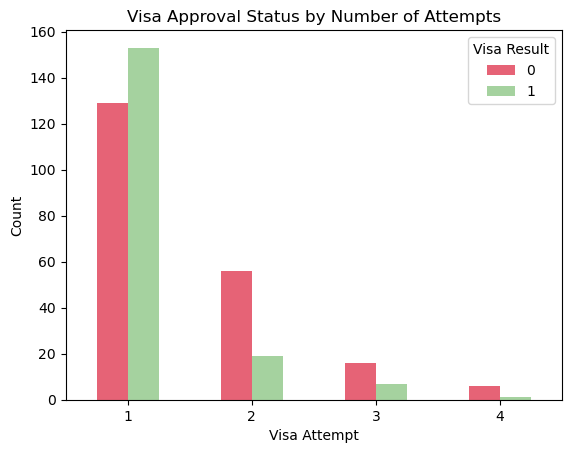

In [133]:
# Group the data by category and visa result, and calculate the counts
counts = train_data_std_7.groupby('Visa Attempt')['Visa Result'].value_counts().unstack()

# Create bar plot
counts.plot.bar(rot=0, color= [red,green])

# Add labels and title
plt.xlabel("Visa Attempt")
plt.ylabel("Count")
plt.title("Visa Approval Status by Number of Attempts")

# Show the chart
plt.show()

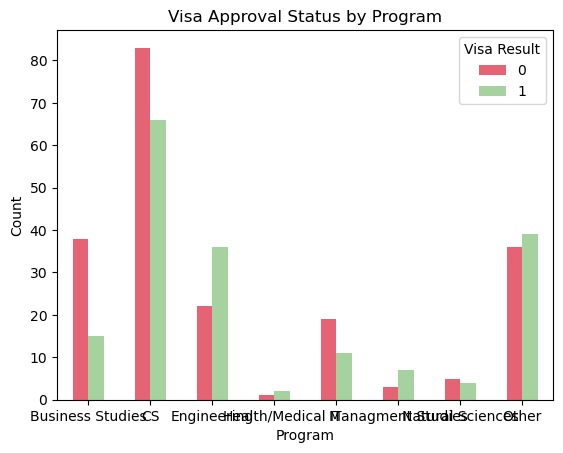

In [134]:
# Group the data by category and visa result, and calculate the counts
counts = train_data_std_7.groupby('Program')['Visa Result'].value_counts().unstack()

# Create bar plot
counts.plot.bar(rot=0, color= [red,green])

# Add labels and title
plt.xlabel("Program")
plt.ylabel("Count")
plt.title("Visa Approval Status by Program")

# Show the chart
plt.show()

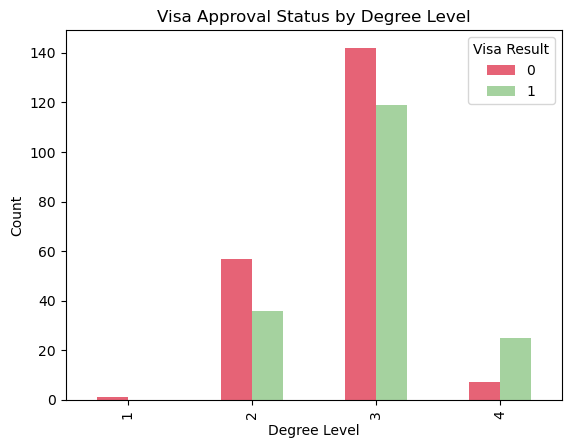

In [135]:
# Group the data by category and visa result, and calculate the counts
counts = training_data.groupby('Degree Level')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])


# Add labels and title
plt.xlabel("Degree Level")
plt.ylabel("Count")
plt.title("Visa Approval Status by Degree Level")

# Show the chart
plt.show()

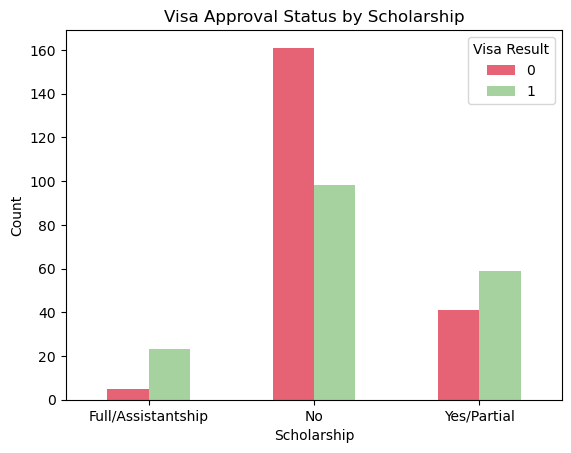

In [136]:
# Group the data by category and visa result, and calculate the counts
counts = training_data.groupby('Scholarship')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Scholarship")
plt.ylabel("Count")
plt.title("Visa Approval Status by Scholarship")
plt.xticks(rotation=0)
# Show the chart
plt.show()


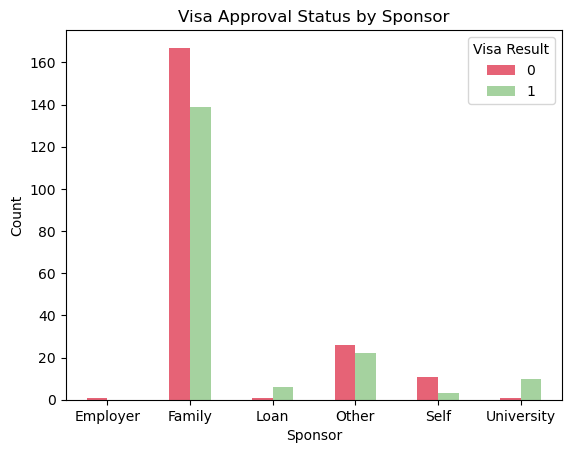

In [137]:
# Group the data by category and visa result, and calculate the counts
counts = training_data.groupby('Sponsor')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Sponsor")
plt.ylabel("Count")
plt.title("Visa Approval Status by Sponsor")
plt.xticks(rotation=0)
# Show the chart
plt.show()

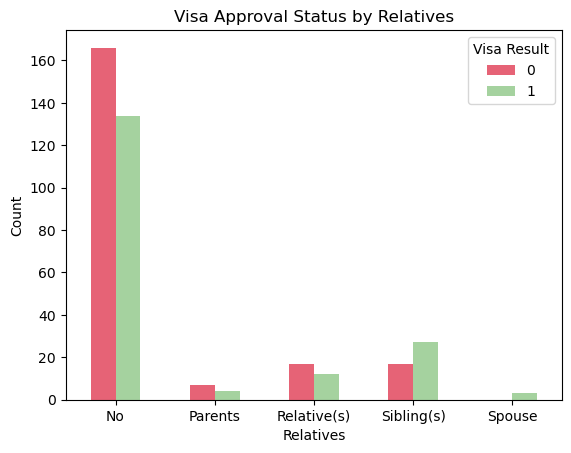

In [138]:
# Group the data by category and visa result, and calculate the counts
counts = training_data.groupby('Relatives')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Relatives")
plt.ylabel("Count")
plt.title("Visa Approval Status by Relatives")
plt.xticks(rotation=0)
# Show the chart
plt.show()

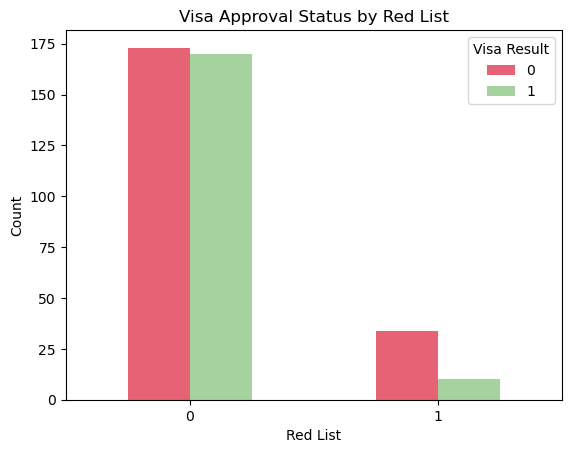

In [139]:
# Group the data by category and visa result, and calculate the counts
counts = training_data.groupby('Red List')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Red List")
plt.ylabel("Count")
plt.title("Visa Approval Status by Red List")
plt.xticks(rotation=0)
# Show the chart
plt.show()

## Pre-Processing

In [140]:
### Breaking Down Data into Numeric and Categorical Features ###
numeric_columns = ['Visa Attempt', 'Degree Level', 'Rank', 'Red List', 'Visa Result']
cat_columns = ['Program', 'Scholarship', 'Sponsor','Relatives'] # 'Sponsor' is not included because it worsned the model

In [141]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(training_data[cat_columns])

with open('inference_files/onehot_encoder.pkl', 'wb') as f:
   pickle.dump(encoder, f)

training_data_num = training_data[numeric_columns]
training_data_cat_np = encoder.transform(training_data[cat_columns])
training_data_cat = pd.DataFrame(data=training_data_cat_np, columns = encoder.get_feature_names_out(input_features=cat_columns))

In [142]:
target_data.reset_index(drop=True, inplace=True)
training_data_cat.reset_index(drop=True, inplace=True)
training_data_num.reset_index(drop=True, inplace=True)
training_data_num = training_data_num.astype(int)
training_data = pd.concat([training_data_num, training_data_cat], axis=1, ignore_index=False)
training_data.head()

,Visa Attempt,Degree Level,Rank,Red List,Visa Result,Program_Business Studies,Program_CS,Program_Engineering,Program_Health/Medical,Program_IT,...,Sponsor_Family,Sponsor_Loan,Sponsor_Other,Sponsor_Self,Sponsor_University,Relatives_No,Relatives_Parents,Relatives_Relative(s),Relatives_Sibling(s),Relatives_Spouse
0,2,3,2,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,4,1,0,1,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,3,2,1,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,3,1,0,0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,3,2,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [143]:
target_train = training_data['Visa Result']
features_train = training_data.drop(['Visa Result'], axis=1)

## Machine Learning Model

In [144]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size = 0.2, random_state=75)

#### Handling Data Imbalance

In [145]:
### Handling Imbalanced Data using SMOTE ###
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [185]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# fix the randomization
np.random.seed(3)
tf.random.set_seed(3)

# Scale the data
scaler = StandardScaler()
X_train_scaled = (X_train)
X_test_scaled = (X_test)

with open('inference_files/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Convert the data to TensorFlow tensors
X_train_scaled = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_scaled = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_scaled = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test_scaled = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [186]:
lamda = 0.0001

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamda), input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), verbose=0)

# Make predictions on the training set
y_pred_train = model.predict(X_train_scaled)


11/11 [==============================] - 0s 2ms/step


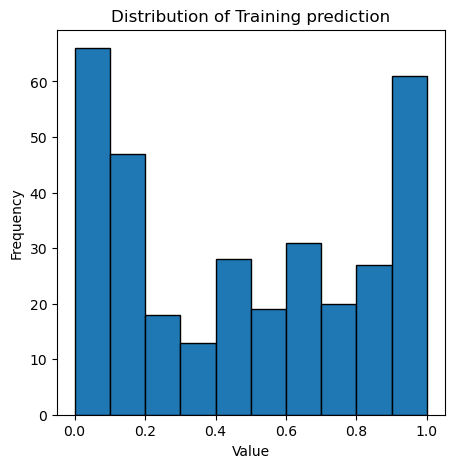

In [187]:
# Define the bin edges.
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(5, 5))
# Plot a histogram.
plt.hist(y_pred_train, bins=bins, edgecolor='black')

# Set the labels and title.
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Training prediction')

# Show the plot.
plt.show()

3/3 [==============================] - 0s 2ms/step


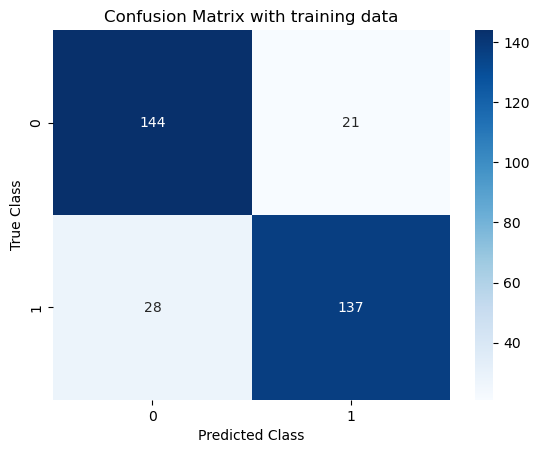

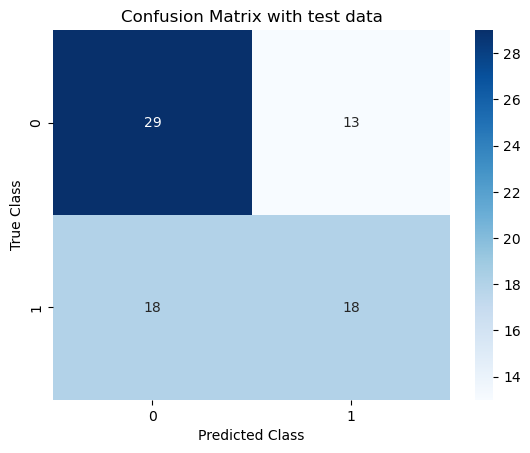

The accuracy with training data is 0.8515151515151516
The accuracy with test data is 0.6025641025641025
Precision: 0.5806451612903226
Recall: 0.5
F1 Score: 0.537313432835821


In [188]:
y_pred_train_bin = y_pred_train > .5
y_pred_train_bin = y_pred_train_bin[:, 0]
conf_matrix_train = confusion_matrix(y_train, y_pred_train_bin)
accuracy_train = accuracy_score(y_train, y_pred_train_bin)

y_pred_test = model.predict(X_test_scaled)
y_pred_test_bin = y_pred_test > .5
y_pred_test_bin = y_pred_test_bin[:, 0]
conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
accuracy_test = accuracy_score(y_test, y_pred_test_bin)

sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with training data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print(f"The accuracy with training data is {accuracy_train}")
print(f"The accuracy with test data is {accuracy_test}")

### calculating the precision, recall and f1 score ###
precision_train = precision_score(y_train, y_pred_train_bin)
recall_train = recall_score(y_train, y_pred_train_bin)
f1_train = f1_score(y_train, y_pred_train_bin)

precision_test = precision_score(y_test, y_pred_test_bin)
recall_test = recall_score(y_test, y_pred_test_bin)
f1_test = f1_score(y_test, y_pred_test_bin)

### printing the precision, recall and f1 score for test set
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

In [189]:
### Printing false negative cases ###
false_negatives = X_test[(y_pred_test_bin == 0) & (y_test == 1)]
false_negatives

,Visa Attempt,Degree Level,Rank,Red List,Program_Business Studies,Program_CS,Program_Engineering,Program_Health/Medical,Program_IT,Program_Managment Studies,...,Sponsor_Family,Sponsor_Loan,Sponsor_Other,Sponsor_Self,Sponsor_University,Relatives_No,Relatives_Parents,Relatives_Relative(s),Relatives_Sibling(s),Relatives_Spouse
119,1,3,2,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
208,1,2,1,0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194,1,3,3,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
266,1,3,2,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
180,1,2,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
73,1,2,3,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
360,1,3,2,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
72,1,2,3,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
118,2,3,2,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
216,1,2,3,0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Saving the Model's Weights

In [150]:
#### Saving the Model weights ####
model.save('inference_files/model.h5')
tf.saved_model.save(model, 'inference_files/model')

INFO:tensorflow:Assets written to: inference_files/model\assets


INFO:tensorflow:Assets written to: inference_files/model\assets


### Random Forest

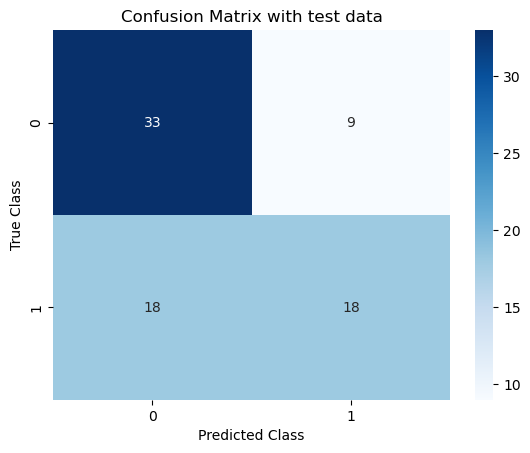

Accuracy: 0.6538461538461539
Precision: 0.6666666666666666
Recall: 0.5
F1 Score: 0.5714285714285715


In [151]:
### applying random forest classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Create the model with 100 trees
abc = AdaBoostClassifier(n_estimators=500, random_state=27, learning_rate=0.1)

# Train the model on training data
abc.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_pred = abc.predict(X_test)

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Callucating precison, recall and f1 score ###
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

### Results

Thus, we conclude that neural network is outperforming the decision trees in this case. Here are some further findings:
1. There is only limited information available in our features. Thus, many same features predict different output. The reason is that our features do not contain that extra piece of information to predict the correct outcome. 
2. The analysis tells that some information is hidden in the actual profile, like past university and course alignment etc. This is not possible to gather the data for all these and train a model on these.
3. We will use the eights of neural networks and use the probability to tell how strong the visa chances for a particular candidate are.

In [152]:
### calling the saved model ###

model = tf.saved_model.load('inference_files/model')
print(model.signatures)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, dense_8_input) at 0x20E543408D0>})
